# Exhaustion_Signal by ChatGPT - Strategy - Backtesting 

### Import Library

In [27]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [28]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [29]:
data = dataset.copy()

In [30]:
# data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2024-11-01 00:00:00']

In [31]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-01 09:00:00,1340.4,1340.4,1337.5,1337.8,10641
2024-11-01 09:05:00,1337.8,1338.6,1337.2,1338.1,5701
2024-11-01 09:10:00,1338.0,1338.0,1336.9,1337.5,3227
2024-11-01 09:15:00,1337.5,1338.0,1337.1,1337.7,2665
2024-11-01 09:20:00,1337.7,1338.8,1337.4,1338.6,3173
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [32]:
def prepare_data(df):
    df['Higher_High'] = df['High'] > df['High'].shift(1)
    df['Lower_Volume'] = df['Volume'] < df['Volume'].shift(1)
    
    df['Exhaustion_Signal'] = df['Higher_High'] & df['Lower_Volume']
    return df

In [33]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [34]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.Exhaustion_Signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == True:
            sell_price = close_price
            sl = sell_price + 3
            tp = sell_price - self.reward_on_risk * 3
            self.sell(size=1, sl=sl, tp=tp)

In [35]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [36]:
stats

Start                     2024-11-01 09:00:00
End                       2025-02-25 14:45:00
Duration                    116 days 05:45:00
Exposure Time [%]                   76.237876
Equity Final [$]                   1523.12008
Equity Peak [$]                    1575.99977
Return [%]                           1.541339
Buy & Hold Return [%]                1.644491
Return (Ann.) [%]                    2.894174
Volatility (Ann.) [%]                7.771598
Sharpe Ratio                         0.372404
Sortino Ratio                         0.53545
Calmar Ratio                         0.789415
Max. Drawdown [%]                   -3.666225
Avg. Drawdown [%]                   -0.398394
Max. Drawdown Duration       58 days 00:45:00
Avg. Drawdown Duration        3 days 02:43:00
# Trades                                  184
Win Rate [%]                        39.673913
Best Trade [%]                       0.705448
Worst Trade [%]                     -0.353432
Avg. Trade [%]                    

In [37]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,24,44,1336.99878,1328.5,8.49878,0.006357,2024-11-01 11:00:00,2024-11-01 14:05:00,None,0 days 03:05:00
1,-1,46,49,1330.20082,1328.8,1.40082,0.001053,2024-11-01 14:15:00,2024-11-01 14:30:00,None,0 days 00:15:00
2,-1,52,75,1330.10085,1321.5,8.60085,0.006466,2024-11-04 09:05:00,2024-11-04 11:00:00,None,0 days 01:55:00
3,-1,86,100,1322.20322,1320.0,2.20322,0.001666,2024-11-04 13:20:00,2024-11-04 14:30:00,None,0 days 01:10:00
4,-1,103,136,1318.60430,1321.9,-3.29570,-0.002499,2024-11-05 09:05:00,2024-11-05 13:15:00,None,0 days 04:10:00
...,...,...,...,...,...,...,...,...,...,...,...
179,-1,3811,3814,1350.69467,1351.4,-0.70533,-0.000522,2025-02-21 14:15:00,2025-02-21 14:30:00,None,0 days 00:15:00
180,-1,3818,3822,1352.39416,1355.9,-3.50584,-0.002592,2025-02-24 09:10:00,2025-02-24 09:30:00,None,0 days 00:20:00
181,-1,3833,3862,1357.59260,1361.0,-3.40740,-0.002510,2025-02-24 10:25:00,2025-02-24 14:15:00,None,0 days 03:50:00
182,-1,3864,3865,1365.39026,1365.2,0.19026,0.000139,2025-02-24 14:25:00,2025-02-24 14:30:00,None,0 days 00:05:00


In [38]:
# bt.plot()

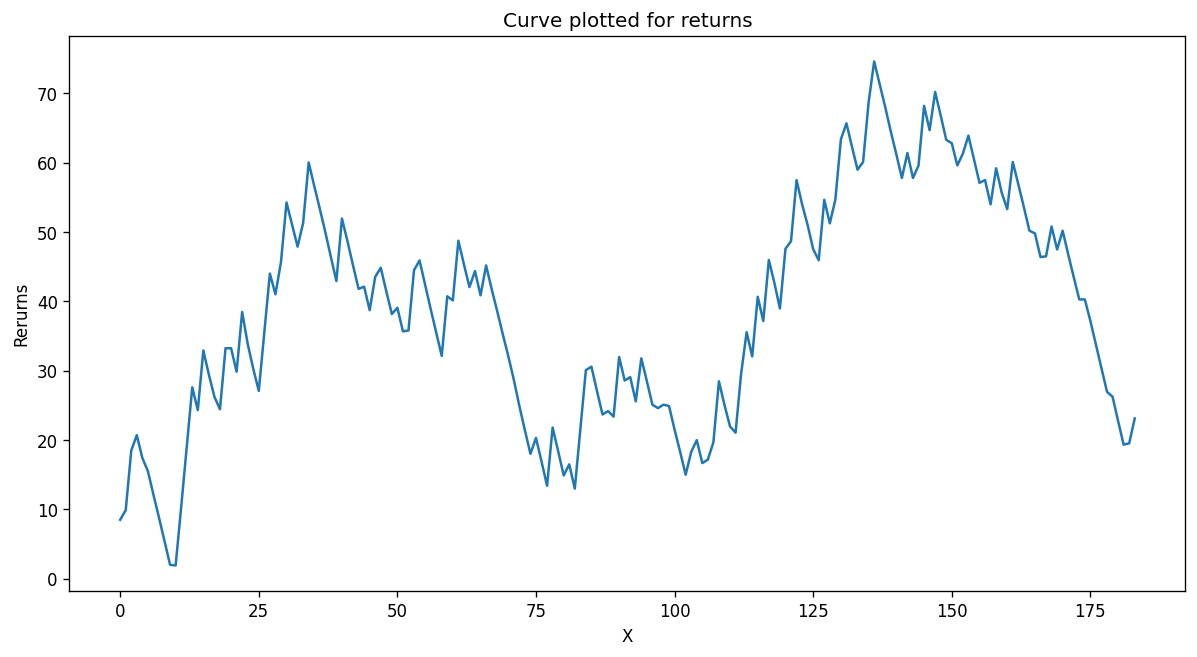

In [39]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()